# Folium-Genus: Deep Neural Network for Leaf Classification

A multiclass Classification problem approached through the powerful DNN framework "TENSORFLOW"

Importing the necessary libraries

In [3]:
from scipy.misc import imread
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from PIL import Image
from scipy import ndimage
import scipy
from numpy import nanmean
%matplotlib inline

This dataset contains images of three different species of leaves with varying indoor backgrounds. the idea here is to implement a deep neural network to classify the unwrapped image pixel data using Google's Tensorflow framework. 
There are 186 images in total with 592x896 pixels in each of the RGB channels.

In [4]:
X= np.zeros((186,592,896,3))

for i in range(0,186):
    name = 'image_'+(str('%.4f' %((i+1)/10000)))[-4:]+'.jpg'
    
    X[i,:,:,:]=imread('D:/NOTBACKEDUP/ML/PortfolioProjects/nn-from-scratch-master/leaves/folium-genus/'+name)    

In [5]:
X.shape

(186, 592, 896, 3)

To reduce the number of pixels and hence the input data to be fed to the neural network, the image is resized to a lower resolution by combining 16 pixels in each direction into one pixel. 

In [7]:

X_orig_2= np.zeros((186,37,56,3))
def downsample(myarr,factor,estimator=nanmean):
    
    ys,xs = myarr.shape
    crarr = myarr[:ys-(ys % int(factor)),:xs-(xs % int(factor))]
    dsarr = estimator( np.concatenate([[crarr[i::factor,j::factor] 
        for i in range(factor)] 
        for j in range(factor)]), axis=0)
    return dsarr



for i in range(0,186):
    for j in range(0,3):
        X_orig_2[i,:,:,j] = ((downsample(X[i,:,:,j], 16)))/255

X_orig = np.zeros((186,37,37,3))
for i in range(0,186):
    for j in range(0,37):
        for k in range(0,37):
            for l in range(0,3):
                X_orig[i,j,k,l] = X_orig_2[i,j,10+k,l]
                
    

In [8]:
Y_orig=np.zeros((1,186), dtype= 'int8')

for i in range(66,126):
    Y_orig[0,i]= int(1)
    
for i in range(126,186):
    Y_orig[0,i]= int(2)

X_orig.shape

(186, 37, 37, 3)

Let's visualize the different leaf species with their tagged class. Here I have randomly picked 20 images for display.

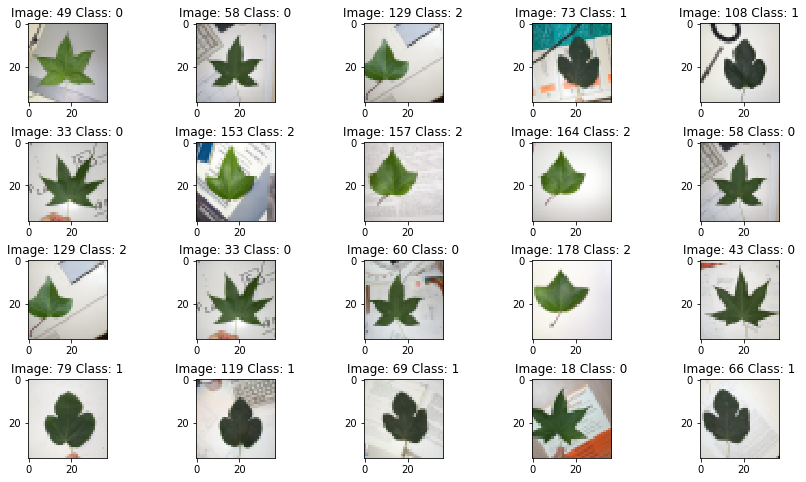

In [26]:
fig, axs = plt.subplots(4,5, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.02)

axs = axs.ravel()
np.random.seed(1048)
for i in range(20):

    index = np.random.randint(185)
    plt.gray()
    axs[i].imshow(X_orig[index])
    axs[i].set_title('Image: '+str(index)+' Class: '+str(Y_orig[0,index]))
    

# Neural Networks

In [10]:
orig_idx = (list(range(0, X_orig.shape[0])))

np.random.shuffle(orig_idx)
tr_idx = orig_idx[0:140]
te_idx = orig_idx[140:186]
X_train_orig = X_orig[tr_idx,:,:,:]
Y_train_orig = Y_orig [:,tr_idx]
X_test_orig = X_orig[te_idx,:,:,:]
Y_test_orig = Y_orig [:,te_idx]


In [11]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [12]:
def random_mini_batches(X, Y, mini_batch_size = 37, seed = 0):
    
    
    m = X.shape[1]                 
    mini_batches = []
    np.random.seed(seed)
    
   
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [13]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [4107, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def forward_propagation_for_predict(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [14]:
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

X_train = X_train_flatten/255
X_test = X_test_flatten/255

Y_train = convert_to_one_hot(Y_train_orig, 3)
Y_test = convert_to_one_hot(Y_test_orig, 3)


In [15]:

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 140
number of test examples = 46
X_train shape: (4107, 140)
Y_train shape: (3, 140)
X_test shape: (4107, 46)
Y_test shape: (3, 46)


In [16]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder( tf.float32, shape=(n_x, None), name='X')
    Y = tf.placeholder( tf.float32, shape=(n_y, None), name='Y')
    return X, Y

In [17]:
X, Y = create_placeholders(6216,3)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(6216, ?), dtype=float32)
Y = Tensor("Y:0", shape=(3, ?), dtype=float32)


In [18]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [25, 4107], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [25, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [3, 12], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [3, 1], initializer = tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [19]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
                  
    Z1 = tf.add(tf.matmul(W1,X), b1)                                             
    A1 = tf.nn.relu(Z1)                                              
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                             
    A2 = tf.nn.relu(Z2)                                             
    Z3 = tf.add(tf.matmul(W3,A2), b3)                                              
    
    
    return Z3, A1, A2
    

In [20]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(4107, 3)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = (<tf.Tensor 'Add_2:0' shape=(3, ?) dtype=float32>, <tf.Tensor 'Relu:0' shape=(25, ?) dtype=float32>, <tf.Tensor 'Relu_1:0' shape=(12, ?) dtype=float32>)


In [21]:
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels= labels))
    
    
    return cost  

In [22]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(4107, 3)
    parameters = initialize_parameters()
    Z3, A1, A2 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [23]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 4000, minibatch_size = 32, print_cost = True):
    tf.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]                            
    costs = []  
    
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    
    Z3, A1, A2 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        
        sess.run(init)
        
        
        for epoch in range(num_epochs):

            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                
                (minibatch_X, minibatch_Y) = minibatch
                
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                
                epoch_cost += minibatch_cost / num_minibatches

            
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.373481
Cost after epoch 100: 1.353045
Cost after epoch 200: 1.303251
Cost after epoch 300: 1.250861
Cost after epoch 400: 1.195818
Cost after epoch 500: 1.136143
Cost after epoch 600: 1.081133
Cost after epoch 700: 1.023250
Cost after epoch 800: 0.889797
Cost after epoch 900: 0.856047
Cost after epoch 1000: 0.792696
Cost after epoch 1100: 0.701080
Cost after epoch 1200: 0.667712
Cost after epoch 1300: 0.641554
Cost after epoch 1400: 0.560838
Cost after epoch 1500: 0.520939
Cost after epoch 1600: 0.462105
Cost after epoch 1700: 0.427735
Cost after epoch 1800: 0.401255
Cost after epoch 1900: 0.393562
Cost after epoch 2000: 0.366406
Cost after epoch 2100: 0.283043
Cost after epoch 2200: 0.256724
Cost after epoch 2300: 0.254345
Cost after epoch 2400: 0.202483
Cost after epoch 2500: 0.185012
Cost after epoch 2600: 0.157984
Cost after epoch 2700: 0.140514
Cost after epoch 2800: 0.130231
Cost after epoch 2900: 0.110337
Cost after epoch 3000: 0.124540
Cost after epoch 310

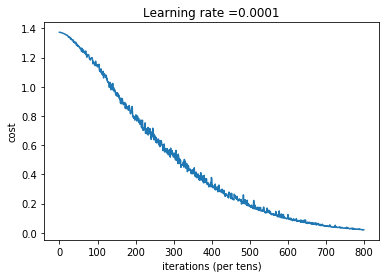

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.717391


In [24]:
parameters = model(X_train, Y_train, X_test, Y_test)

Original Class1
Predicted Class: 1


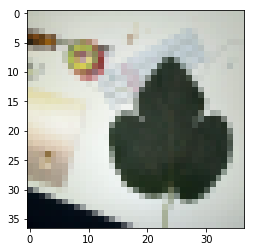

Original Class1
Predicted Class: 1


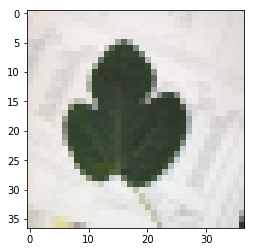

Original Class0
Predicted Class: 0


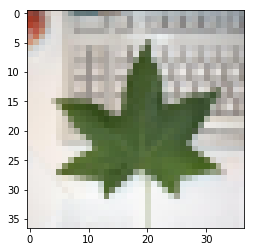

Original Class1
Predicted Class: 1


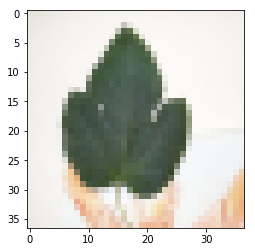

Original Class0
Predicted Class: 0


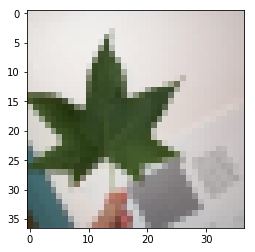

Original Class1
Predicted Class: 1


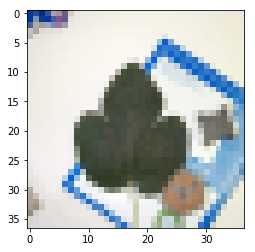

Original Class1
Predicted Class: 1


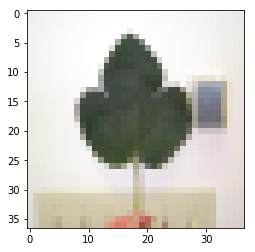

Original Class1
Predicted Class: 0


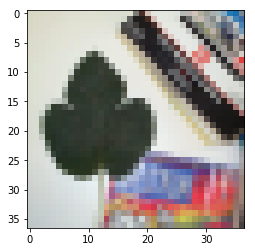

Original Class1
Predicted Class: 1


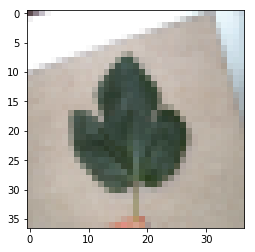

Original Class2
Predicted Class: 2


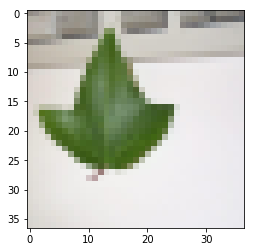

Original Class0
Predicted Class: 2


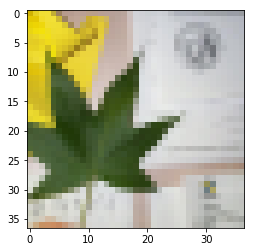

Original Class0
Predicted Class: 0


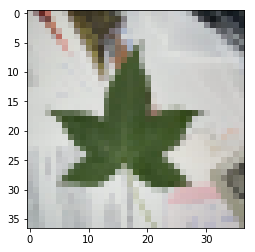

Original Class2
Predicted Class: 2


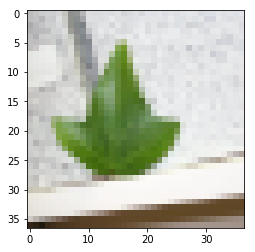

Original Class0
Predicted Class: 0


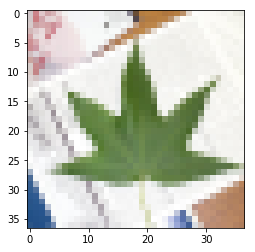

Original Class0
Predicted Class: 2


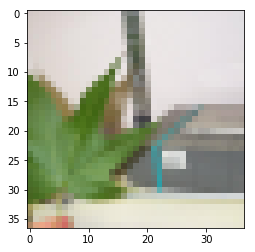

Original Class1
Predicted Class: 1


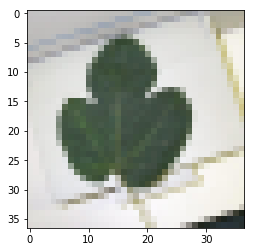

Original Class0
Predicted Class: 0


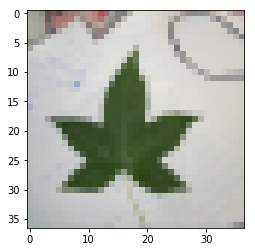

Original Class0
Predicted Class: 2


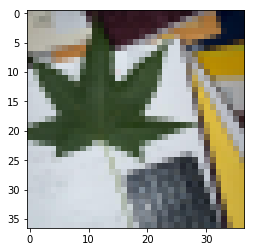

Original Class2
Predicted Class: 0


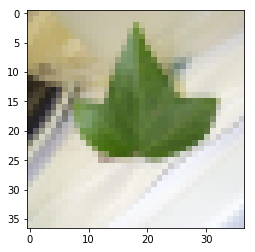

Original Class1
Predicted Class: 1


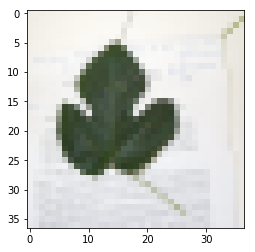

Original Class2
Predicted Class: 2


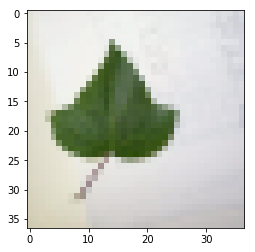

Original Class1
Predicted Class: 0


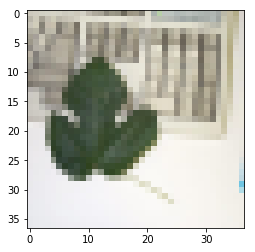

Original Class2
Predicted Class: 2


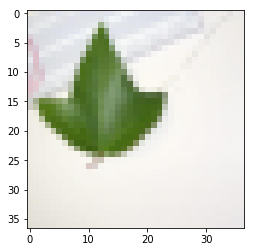

Original Class1
Predicted Class: 1


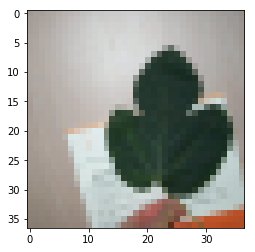

Original Class0
Predicted Class: 0


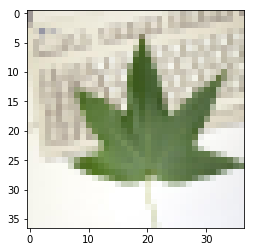

Original Class2
Predicted Class: 2


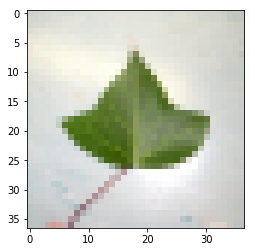

Original Class2
Predicted Class: 2


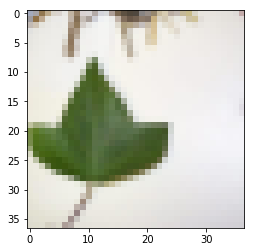

Original Class0
Predicted Class: 0


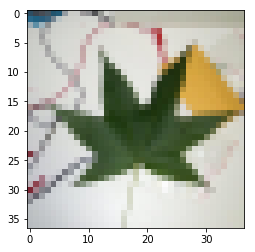

Original Class1
Predicted Class: 1


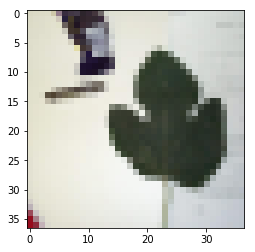

Original Class2
Predicted Class: 2


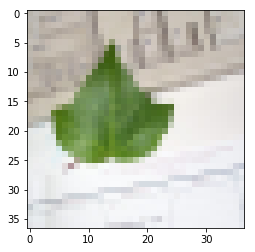

Original Class0
Predicted Class: 0


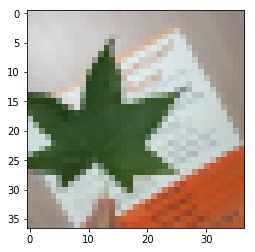

Original Class2
Predicted Class: 2


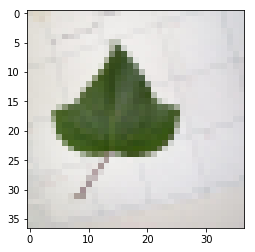

Original Class0
Predicted Class: 0


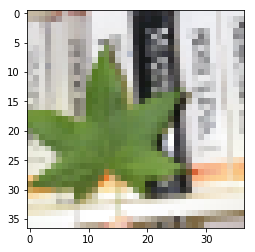

Original Class2
Predicted Class: 1


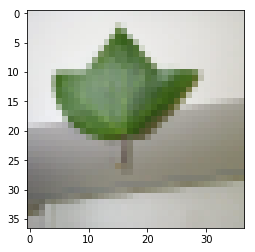

Original Class1
Predicted Class: 1


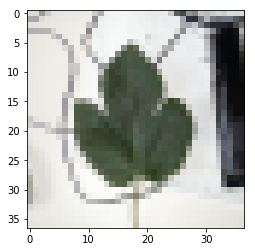

Original Class2
Predicted Class: 2


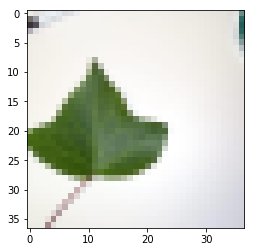

Original Class2
Predicted Class: 2


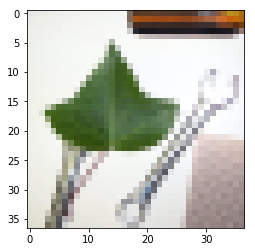

Original Class0
Predicted Class: 0


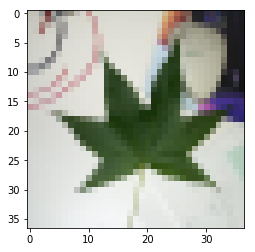

Original Class1
Predicted Class: 1


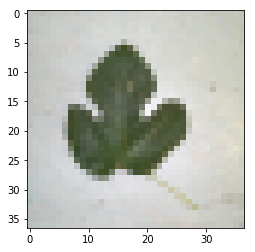

Original Class2
Predicted Class: 0


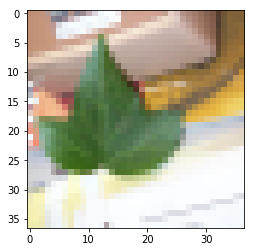

Original Class2
Predicted Class: 2


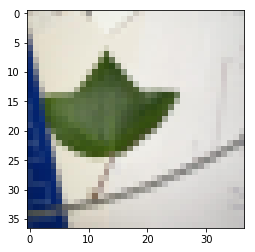

Original Class1
Predicted Class: 1


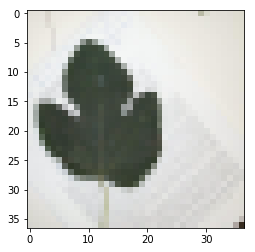

Original Class1
Predicted Class: 1


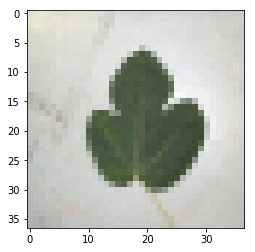

Original Class0
Predicted Class: 0


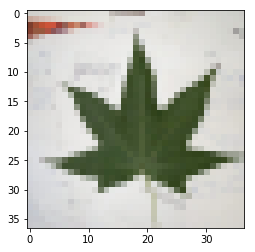

Original Class1
Predicted Class: 1


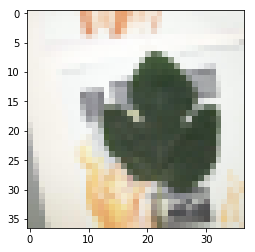

Original Class2
Predicted Class: 0


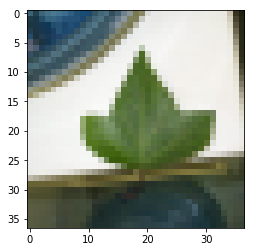

In [26]:
for j in range(0,46):
    plt.imshow(X_test_orig[j,:,:,:])
    
    print("Original Class"+str(Y_test_orig[0,j]))
    print("Predicted Class: "+str(np.squeeze(predict(X_test[:,j].reshape(4107,1),parameters))))
    plt.show()
    